In [75]:
from pathlib import Path
import zipfile
import re
from functools import partial
from fastai.vision.all import *
from fastbook import *

# Synthetic Data - download and unzip

Download the data from https://github.com/microsoft/FaceSynthetics

* 100: https://facesyntheticspubwedata.blob.core.windows.net/iccv-2021/dataset_100.zip
* 1000: xxx
* 100,000: xxx


Data structure:
```
dataset.zip
├── {frame_id}.png        # Rendered image of a face
├── {frame_id}_seg.png    # Segmentation image, where each pixel has an integer value mapping to the categories below
├── {frame_id}_ldmks.txt  # Landmark annotations for 70 facial landmarks (x, y) coordinates for every row
```

In [76]:
!ls ../../Downloads

About Downloads.lpdf                  dataset_100 (1).zip
Bildkonzept GS1.pdf                   dataset_100 (2).zip
ForderungskaufvertragIbeo-Blanco.pdf  dataset_100.zip
Wagstaff_Docs.pdf                     synology-cloud-station-drive-4339.dmg


In [77]:
# download data to here
synthetic_data_zip = "../../Downloads/dataset_100.zip"


# could use 
# download_url(searched_imgs[0], dest=dest)
# mkdir -p DigitalOcean-Wget-Tutorial/Downloads
# wget https://code.jquery.com/jquery-3.6.0.min.js -P dire_prefix

In [78]:
data_dir = Path("./data")
synthetic_data_dir = data_dir / "synthetic"
real_data_dir = data_dir / "real"

In [79]:
def unzip(zipfile_path: Path, destination: Path):
    with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
        zip_ref.extractall(destination)

In [80]:
# unzip(synthetic_data_zip, synthetic_data_dir)

In [81]:
#!ls data

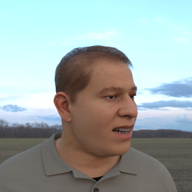

In [82]:
# Look at an example image
ex_syn_img = "000000.png"
img = PILImage.create(synthetic_data_dir/ex_syn_img)
img.to_thumb(192)

In [51]:
def get_image_files_filtered(path, pattern):
    fns = get_image_files(path)
    return L([f for f in fns if pattern.match(f.stem)])

In [52]:
fns = get_image_files(directory_to_extract_to)
fns

(#200) [Path('data/000058_seg.png'),Path('data/000048_seg.png'),Path('data/000032.png'),Path('data/000026.png'),Path('data/000083_seg.png'),Path('data/000093_seg.png'),Path('data/000067_seg.png'),Path('data/000077_seg.png'),Path('data/000027.png'),Path('data/000033.png')...]

In [54]:
# Folter for only rendered imgaes, we do not want the semantic segmentation images
fns_filtered = get_image_files_filtered(directory_to_extract_to, re.compile("^[0-9]{6}$"))
fns_filtered

(#100) [Path('data/000032.png'),Path('data/000026.png'),Path('data/000027.png'),Path('data/000033.png'),Path('data/000019.png'),Path('data/000025.png'),Path('data/000031.png'),Path('data/000030.png'),Path('data/000024.png'),Path('data/000018.png')...]

In [18]:
failed = verify_images(fns)
failed

(#0) []

# Real Data - search and download

In [83]:
# DuckDuckGo search
?search_images_ddg

In [68]:
searched_imgs = search_images_ddg("portrait")
len(searched_imgs)

200

In [85]:
download_images(real_data_dir, urls=searched_imgs)

In [86]:
real_fns = get_image_files(real_data_dir)
real_fns

(#196) [Path('data/real/78904dd2-175d-4d5d-b3d2-53e8d232787c.jpg'),Path('data/real/c72fe42d-b986-43db-8e35-ba5e92544112.jpg'),Path('data/real/49cbe7c7-5ee8-4571-846e-94fdaf484e58.jpg'),Path('data/real/d217dba1-d22b-4c6b-9db5-3523dfe97a39.jpg'),Path('data/real/e219cfb2-6513-4cc2-b6c4-f1313145a43d.jpg'),Path('data/real/38c6f933-3b04-4209-a6fa-0dae59dc79ac.jpg'),Path('data/real/38ab9147-37c7-4cd9-9de7-cb2caa24da1e.jpg'),Path('data/real/ddd8412e-cadb-4238-968e-75dcd46042bd.jpg'),Path('data/real/dfa43e57-2815-48d8-9c54-5f460de61660.jpg'),Path('data/real/65953ed9-b14e-4fd0-a056-c2d9e8dc4194.jpg')...]

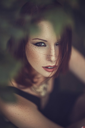

In [87]:
im = Image.open(real_fns[0])
im.to_thumb(128,128)

In [88]:
real_failed = verify_images(real_fns)
real_failed

(#2) [Path('data/real/ed2e43b5-25b5-4ea4-8bdc-1abb5be7ee8f.jpg'),Path('data/real/874f7d0f-2678-4109-91b8-ce2ad8bdeafa.jpg')]

In [89]:
real_failed.map(Path.unlink)

(#2) [None,None]

# fastai DataBlock, DataLoaders

In [125]:
# real data patter: ffeee5d8-c439-4fd2-b09e-e9c58d2b5670
# synthetic data patter: 123456

pattern = re.compile("^[0-9]{6}$|^[A-Za-z0-9]{8}-[A-Za-z0-9]{4}-[A-Za-z0-9]{4}-[A-Za-z0-9]{4}-[A-Za-z0-9]{12}$")

A DataBlock object is like a template for creating a DataLoaders.

In [126]:
get_items = partial(get_image_files_filtered, pattern=pattern)

In [132]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_items, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [133]:
# tell fastai the actual source of our data—in this case, the path where the images can be found
dls = bears.dataloaders(data_dir)

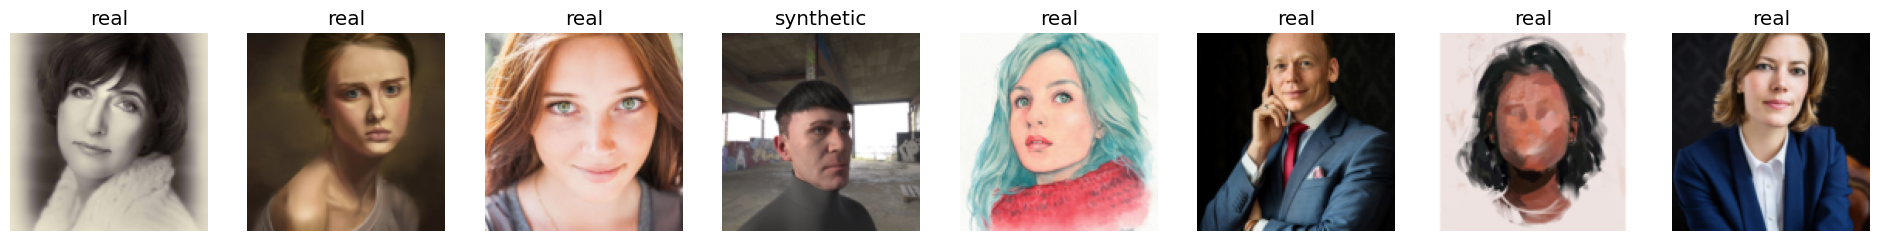

In [134]:
dls.valid.show_batch(max_n=8, nrows=1)

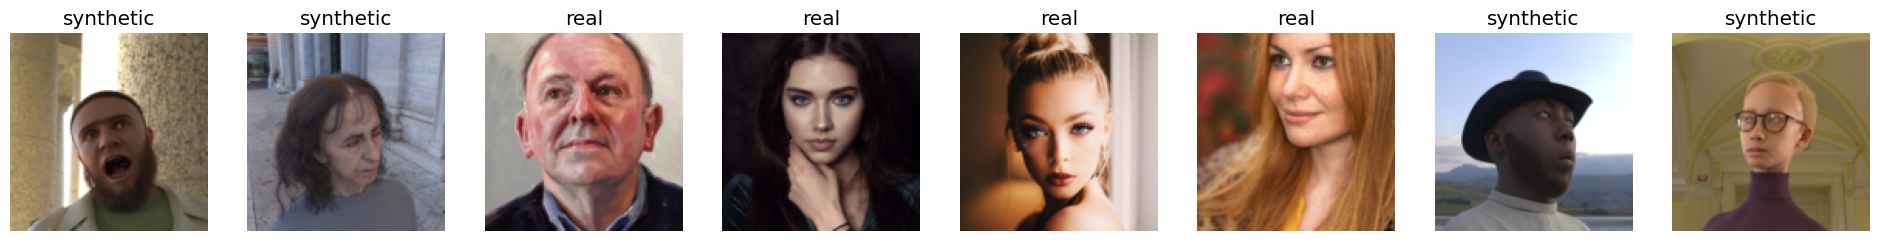

In [135]:
dls.train.show_batch(max_n=8, nrows=1)

# TODO

* Get datasets as persistent data in Paperspace
    * how to get the curated real dataset persistent, also so that we can grown this?
* Run first training in Paperspace
